## <u>Introduction</u>

We are using data-set from https://myleott.com/op-spam. And the discription of the given data is as follows:-
* 400 truthful positive reviews from TripAdvisor (described in [1])
* 400 deceptive positive reviews from Mechanical Turk (described in [1])
* 400 truthful negative reviews from Expedia, Hotels.com, Orbitz, Priceline, TripAdvisor and Yelp (described in [2])
* 400 deceptive negative reviews from Mechanical Turk (described in [2])

## <u>Main sub-tasks our process will consist</u>

This project can be compared to a research process where we look at which machine learning models and which information in the reviews is most reliable for producing the required task which is again detecting spam.

* Cleaning and preparation of each review we retrieve from the given folders.
* Introducing machine learning models
* Implimentation and testing of models


## <u>Supervised Learning</u>

Based on the first meeting with our mentor, Rahul and our own research it has been a desire to use supervised machine learning in this project. This type of machine learning is often used for automatic detection and involves training a machine learning model with large amounts of data that is also marked with a correct description of what the data contains, like ours. Here we can come up with many examples and to mention one of them we could give a model thousands of pictures of dogs and cats, along with a label for each picture that said whether it is was a dog or a cat. During the training process, the model will constantly try to guess the content of the pictures and improve based on whether it guessed right or wrong.
<br>
In other words, each review we use to train the model must be marked with deceptive/truthful so that we can get the model to learn from.


## <u>Importing libraries</u>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold


import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout


In [3]:
import os
import numpy as np
import pandas as pd
from os import walk
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from IPython.display import Image
import nltk
nltk.download("stopwords")
import spacy
from nltk.corpus import stopwords as nltk_stop
from nltk import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tsegazabtesfay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### <div class="alert alert-info">We started by making a function for retrieval data-sets</div>

In [4]:
# Paths for a given folder
d = ["./op_spam_v1.4/negative_polarity/deceptive_from_MTurk",
     "./op_spam_v1.4/negative_polarity/truthful_from_Web",
     "./op_spam_v1.4/positive_polarity/deceptive_from_MTurk",
     "./op_spam_v1.4/positive_polarity/truthful_from_TripAdvisor"]

def readDataSet(data):
    """
    param : list of paths 
    """
    opinions = []
    for mypath in data:
        for (dirpath, dirnames, filenames) in walk(mypath):
            i = 0
            for f in listdir(dirpath):
                if isfile(join(dirpath, f)):
                    i+=1
                    ff = f.split('_')
                    file = open(dirpath+'/'+f,"r")
                    opinion = file.read()
                    file.close()
                    if(mypath.endswith("negative_polarity/deceptive_from_MTurk") ):
                        opinions.append(['deceptive','negative','MTurk',ff[1],opinion])
                    elif(mypath.endswith("negative_polarity/truthful_from_Web")):
                        opinions.append(['truthful','negative','Web',ff[1],opinion])
                    elif(mypath.endswith("positive_polarity/deceptive_from_MTurk")):
                        opinions.append(['deceptive','positive','MTurk',ff[1],opinion])
                    else:
                        opinions.append(['truthful','positive','TripAdvisor',ff[1],opinion])
    return opinions
r = readDataSet(d)    

In [5]:
# arranging as a dataframe 
df = pd.DataFrame(r, columns=['classification', 'polarity','source', 'hotel', 'review'])


In [6]:
df.head()

,classification,polarity,source,hotel,review
0,deceptive,negative,MTurk,talbott,The Talbott Hotel claims to be Chicago's Premi...
1,deceptive,negative,MTurk,talbott,I selected The Talbott for my recent family va...
2,deceptive,negative,MTurk,affinia,I recently stayed at the Affinia Hotel in Chic...
3,deceptive,negative,MTurk,hardrock,My husband and I stayed here at the Hard Rock ...
4,deceptive,negative,MTurk,hardrock,I stayed at the Hard Rock Hotel in Chicago rec...


#### Observation
<div class="alert alert-warning">
Saving to csv-format for availability from any pc reason, i.e avoiding worrying about the path of folders during runing the <code>readDataSet</code> function.
</div>

In [4]:
# Save as csv-format
write_path = "Op_spam.csv"
df.to_csv(path_or_buf=write_path, sep=';')

In [217]:
path = "./Op_spam.csv"
data = pd.read_csv(path, delimiter=";")
d_copy = data.copy() # prefer to use copy for keeping the original as it is.


In [218]:
d_copy = pd.DataFrame(d_copy, columns=["index", "classification", "polarity", "source", "hotel", "review"])
d_copy["index"] = np.arange(0, len(d_copy))


In [219]:
d_copy["source"].unique()

array(['MTurk', 'Web', 'TripAdvisor'], dtype=object)

## <u>Exploration of reviews and analysis</u>

In this project we have only 1600 reviews which is very small data when one works with machine learning, but we believe it is good enough to show the process which is written at the begning of this file. To explore the reviews, we have used the Python library Pandas in jupyter notebook and jupyter lab.
<br>
Pandas allows us to load data as tables and offers a number of functions for easy analysis, such as seeing the number of rows and columns, data types, the number of unique values in different columns and so on.
</div>

In [220]:
# for simplicity sake
index = "index"
classifications = "classification"
polarities = "polarity"
sources = "source"
hotels = "hotel"
reviews = "review"

<div class="alert alert-info">
    Let's start by seeing the external information which are readable from the <code>Op_Spam.csv</code> without going in to the reviews.   
</div>

In [132]:
print("Total number of hotels: ",len(d_copy[hotels].unique()), "\n\nAnd their names: \n\n",d_copy[hotels].unique())

Total number of hotels:  20 

And their names: 

 ['talbott' 'affinia' 'hardrock' 'ambassador' 'intercontinental' 'palmer'
 'amalfi' 'allegro' 'swissotel' 'knickerbocker' 'homewood' 'sheraton'
 'omni' 'hyatt' 'conrad' 'fairmont' 'sofitel' 'monaco' 'hilton' 'james']


In [133]:
print("Number of reviews: ", len(d_copy))

Number of reviews:  1602


In [11]:
#About 1600 reviews and 6 columns. We've made one extra columns called "index" for simplicity sake
d_copy.shape

(1602, 6)

In [12]:
# The source for the reviews
print(d_copy[sources].unique())

['MTurk' 'Web' 'TripAdvisor']


In [13]:
# The classification it has been given
print(d_copy[classifications].unique())

['deceptive' 'truthful']


In [14]:
# And the polarity given by the reviews provider
print(d_copy[polarities].unique())

['negative' 'positive']


In [15]:
# The first five rows looks like this:
d_copy.head()

,index,classification,polarity,source,hotel,review
0,0,deceptive,negative,MTurk,talbott,The Talbott Hotel claims to be Chicago's Premi...
1,1,deceptive,negative,MTurk,talbott,I selected The Talbott for my recent family va...
2,2,deceptive,negative,MTurk,affinia,I recently stayed at the Affinia Hotel in Chic...
3,3,deceptive,negative,MTurk,hardrock,My husband and I stayed here at the Hard Rock ...
4,4,deceptive,negative,MTurk,hardrock,I stayed at the Hard Rock Hotel in Chicago rec...


The reviews from MTurk 801
The reviews from Web 400
The reviews from TripAdvisor 401


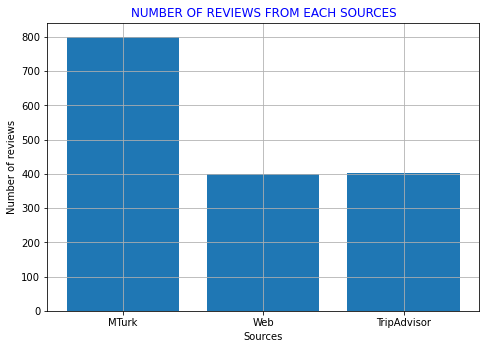

In [16]:
# Number of reviews from each source
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
def numberReviewsFromSources():
    rev = []
    name = []
    for source in d_copy[sources].unique():
        print("The reviews from " + str(source), d_copy[sources].where(d_copy[sources] == source).count())
        rev.append(d_copy[sources].where(d_copy[sources] == source).count())
        name.append(source)
    ax.bar(name, rev)
    plt.title("Number of reviews from each sources".upper(), color="b")
    plt.ylabel("Number of reviews")
    plt.xlabel("Sources")
    plt.grid()
    plt.show()
numberReviewsFromSources()

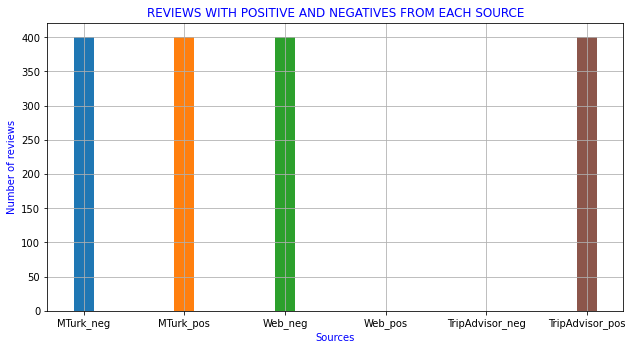

In [331]:
# Number of reviews with positive and negatives from each source
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
def numberReviewsFromSourcesPositiveNegatives():
    sor = d_copy[sources].unique()
    s = ["MTurk_neg", "MTurk_pos", "Web_neg", "Web_pos", "TripAdvisor_neg", "TripAdvisor_pos"]
    MTurk_neg = 0
    MTurk_pos = 0
    Web_neg = 0
    Web_pos = 0
    TripAdvisor_neg = 0
    TripAdvisor_pos = 0
    
    for i in range(len(d_copy)):
        if(d_copy[polarities][i] == "negative" and d_copy[sources][i] == sor[0]):
            MTurk_neg += 1
        elif(d_copy[polarities][i] == "positive" and d_copy[sources][i] == sor[0]):
            MTurk_pos += 1
        elif(d_copy[polarities][i] == "negative" and d_copy[sources][i] == sor[1]):
            Web_neg += 1
        elif(d_copy[polarities][i] == "positive" and d_copy[sources][i] == sor[1]):
            Web_pos += 1
        elif(d_copy[polarities][i] == "negative" and d_copy[sources][i] == sor[2]):
            TripAdvisor_neg += 1
        else:
            TripAdvisor_pos += 1
                
    ax.bar(s[0], MTurk_neg, width = 0.2)
    ax.bar(s[1], MTurk_pos, width = 0.2)
    ax.bar(s[2], Web_neg, width = 0.2)
    ax.bar(s[3], Web_pos, width = 0.2)
    ax.bar(s[4], TripAdvisor_neg, width = 0.2)
    ax.bar(s[5], TripAdvisor_pos, width = 0.2)
    plt.title("reviews with positive and negatives from each source".upper(), color="b")
    plt.ylabel("Number of reviews", color="b")
    plt.xlabel("Sources", color="b")
    plt.grid()
    plt.show()
            
numberReviewsFromSourcesPositiveNegatives()

#### Observation
<div class="alert alert-warning">
Here we can see that we don't have any positive review from web source and any negative review from TripAdvisor.
</div>

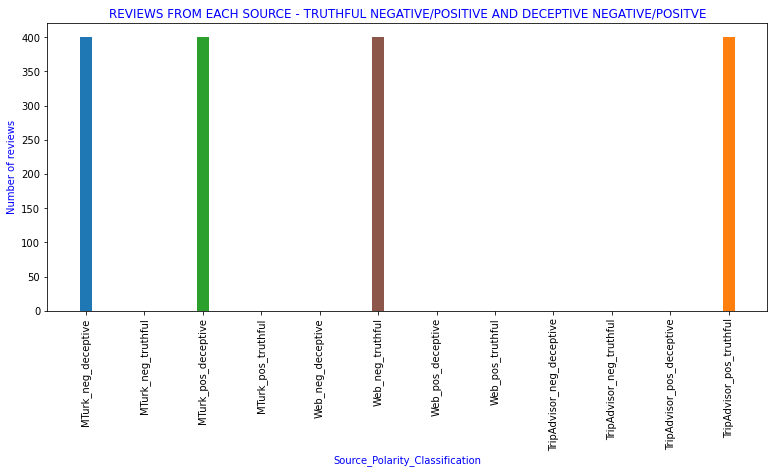

In [342]:
# The number of reviews from each source - truthful negative/positive and deceptive negative/positve

fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
sorce = d_copy[sources].unique()
#'MTurk' 'Web' 'TripAdvisor'
pol = d_copy[polarities].unique()
# 'negative' 'positive'
clas = d_copy[classifications].unique()
# 'deceptive' 'truthful'
def Opinion():
    s = ["MTurk_neg", "MTurk_pos", "Web_neg", "Web_pos", "TripAdvisor_neg", "TripAdvisor_pos"]
    MTurk_neg_truthful = 0
    MTurk_neg_deceptive = 0
    MTurk_pos_truthful = 0
    MTurk_pos_deceptive = 0
    Web_neg_truthful = 0
    Web_neg_deceptive = 0
    Web_pos_truthful = 0
    Web_pos_deceptive = 0
    TripAdvisor_neg_truthful = 0
    TripAdvisor_neg_deceptive = 0
    TripAdvisor_pos_truthful = 0
    TripAdvisor_pos_deceptive = 0
    
    for i in range(len(d_copy)):
        if(d_copy[sources][i] == sorce[0] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[0]):
            MTurk_neg_deceptive += 1
        elif(d_copy[sources][i] == sorce[0] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[1]):
            MTurk_neg_truthful += 1
        elif(d_copy[sources][i] == sorce[0] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[0]):
            MTurk_pos_deceptive += 1
        elif(d_copy[sources][i] == sorce[0] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[1]):
            MTurk_pos_truthful += 1  
            
        elif(d_copy[sources][i] == sorce[1] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[0]):
            Web_neg_deceptive += 1
        elif(d_copy[sources][i] == sorce[1] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[1]):
            Web_neg_truthful += 1
        elif(d_copy[sources][i] == sorce[1] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[0]):
            Web_pos_deceptive += 1
        elif(d_copy[sources][i] == sorce[1] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[1]):
            Web_pos_truthful += 1
            
        elif(d_copy[sources][i] == sorce[2] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[0]):
            TripAdvisor_neg_deceptive += 1
        elif(d_copy[sources][i] == sorce[2] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[1]):
            TripAdvisor_neg_truthful += 1
        elif(d_copy[sources][i] == sorce[2] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[0]):
            TripAdvisor_pos_deceptive += 1
        else:
            TripAdvisor_pos_truthful += 1
            
    ax.bar("MTurk_neg_deceptive", MTurk_neg_deceptive, width = 0.2)
    ax.bar("MTurk_neg_truthful", MTurk_neg_truthful, width = 0.2)
    ax.bar("MTurk_pos_deceptive", MTurk_pos_deceptive, width = 0.2)
    ax.bar("MTurk_pos_truthful", MTurk_pos_truthful, width = 0.2)
    ax.bar("Web_neg_deceptive", Web_neg_deceptive, width = 0.2)
    ax.bar("Web_neg_truthful", Web_neg_truthful, width = 0.2)
    ax.bar("Web_pos_deceptive", Web_pos_deceptive, width = 0.2)
    ax.bar("Web_pos_truthful", Web_pos_truthful, width = 0.2)
    ax.bar("TripAdvisor_neg_deceptive", TripAdvisor_neg_deceptive, width = 0.2)
    ax.bar("TripAdvisor_neg_truthful", TripAdvisor_neg_truthful, width = 0.2)
    ax.bar("TripAdvisor_pos_deceptive", TripAdvisor_pos_deceptive, width = 0.2)
    ax.bar("TripAdvisor_pos_truthful", TripAdvisor_pos_truthful, width = 0.2)
    plt.xticks(rotation=90)
    plt.title("reviews from each source - truthful negative/positive and deceptive negative/positve".upper(), color="b")
    plt.ylabel("Number of reviews", color="b")
    plt.xlabel("Source_Polarity_Classification", color="b")
    plt.show()
            
Opinion()

#### Observation
<div class="alert alert-warning">
In the above bar-graph we have shown where exactly the deceptive and truthful originated from. And for more explanatory way, we would perform like the picture below.
</div>

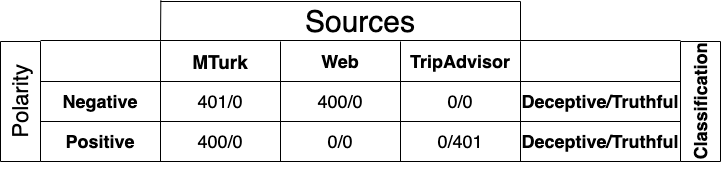

In [334]:
# for more descriptive how the number of reviews classified
Image(filename="T_D.png", width=600, height=300)

<div class="alert alert-info">
    Lets now see a little deeper to the reviews part:
</div>

## <u>Cleaning data</u>

* It may make sense to classify based on keywords, rather than sentence structure and other more complicated elements of the text data. To facilitate models's ability to recognize keywords, we will then clear the english-stopwords and numbers which are stored as a string.

In [174]:
# stop-words we have in english
stop_words_list = []
# Assuming we only have english words in the reviews
stopwords = set(nltk_stop.words("english"))
for i in stopwords:
    stop_words_list.append(i)
print(len(stop_words_list))

179


* => we have about 179 english-stopwords and some examples of them are:

In [18]:
print(stop_words_list[:10])

['ourselves', 'below', 'both', 'm', 'through', 'yourself', 'over', 'my', 'against', "don't"]


* Then clearing out the stopwords and numbers from all the reviews, since we want to avoid as much as confiusing words which can :

In [175]:
# clearing stopwords and alnum
def clearStopWordsAln():
    all_rev_data = []
    
    for r in d_copy[reviews]:
        words = r.split()
        new_words = []
        for word in words:
            w = word.lower()
            if((w not in stop_words_list) and (w.isnumeric()==False)):
                new_words.append(w)
            else:
                continue
        all_rev_data.append(new_words)
        
    return all_rev_data

all_rev_data = clearStopWordsAln()

* We can see the difference on number of all words in reviews before and after the stopwords cleared out.

In [176]:
sum_orginal = 0
sum_cleaned = 0
for i in range(len(d_copy)):
    sum_orginal += len(d_copy[reviews][i].split(" "))
    sum_cleaned += len(all_rev_data[i])
print("*"*100)
print("Original words: ", sum_orginal)
print("Without stopwords & alnum: ", sum_cleaned)
print("Difference : ", sum_orginal - sum_cleaned)
print(len(all_rev_data))

****************************************************************************************************
Original words:  238967
Without stopwords & alnum:  120522
Difference :  118445
1602


* We can also see the main words listed on x-axis visually and their frequencies. F.ex for index 10

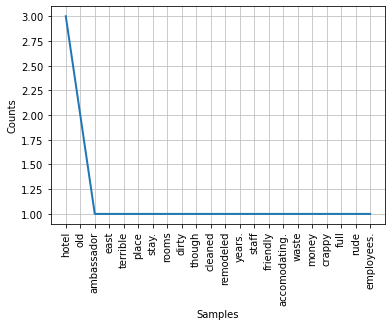

['ambassador', 'east', 'hotel', 'terrible', 'place', 'stay.', 'rooms', 'old', 'dirty', 'though', 'cleaned', 'remodeled', 'years.', 'hotel', 'staff', 'friendly', 'accomodating.', 'waste', 'money', 'crappy', 'old', 'hotel', 'full', 'rude', 'employees.']


In [177]:
# words has been used in a specific review(index=10)
# (i.e words with out stop words)
freq = nltk.FreqDist(all_rev_data[10])
freq.plot(len(all_rev_data[10]), cumulative=False)
plt.show()
print((all_rev_data[10]))

* Another thing we want to mention is that there are several reviews without including the name of any hotel in them, that might have some influence on training the models we are going to use. To point out on how many of them, we have <code>reviewWithOutHotelName</code> function:

In [178]:
def reviewWithOutHotelName():
    count = 0
    for r in all_rev_data:
        for w in r:
            if (w in d_copy[hotels].unique()):
                count += 1
    print("Reviews withou the name of hotel: ",len(d_copy[reviews]) - count)
reviewWithOutHotelName()

Reviews withou the name of hotel:  211


* Here we just pack up again as a normal text to make ready for training the model:

In [179]:
reviews_text = []
for rev in all_rev_data:
    #print(rev)
    st = ""
    for w in rev:
        st += w + " "
    reviews_text.append(st)


#### <u>Two classes</u>
These classes makes the process formal both for the input as text and output which is the result as a truthful or deceptive.


In [206]:
class Classifier:
    Truthful = "truthful".upper()
    Falseful = "deceptive".upper()
class Re:
    def __init__(self, classification, polarity, source, hotel, review):
        self.classification = classification
        self.polarity = polarity
        self.source = source
        self.hotel = hotel
        self.review = review
        self.result = self.geter()
        
    def geter(self):
        if(self.classification == "deceptive" and (self.polarity == "negative" or self.polarity == "positive")):
            return Classifier.Falseful
        if(self.classification == "truthful" and(self.polarity == "negative" or self.polarity == "positive")):
            return Classifier.Truthful

In [207]:
rs = []
for i in range(len(d_copy)):
    rs.append(Re(d_copy["classification"][i], d_copy["polarity"][i],
                 d_copy["source"][i], d_copy["hotel"][i], reviews_text[i]))

## <u>Preparation of data</u>

* Lets began with 70% of data for training and the rest for testing.

In [208]:
training, test = train_test_split(rs, test_size=0.3, random_state=42)
print("Number of reviews used for training:", len(training))
print("Number of reviews used for testing:",len(test))


Number of reviews used for training: 1121
Number of reviews used for testing: 481


In [209]:
train_x = [x.review for x in training]
train_y = [x.result for x in training]

test_x = [x.review for x in test]
test_y = [x.result for x in test]


#### Vectorization

* Models we are going to use do not accept plain text as input and only work with numbers. Therefore, we had to find a method to represent the reviews as numbers, more specifically as vectors or matrices. There are several ways to do this, but we have mainly used countervectorizer in scikit-learn implementation. <code>We will also show the use "tf-idf"</code>, which is another type of wordembedding which is also more popular on some of the models we will pick up.Tf-idf stands for term frequency - inverse document frequency. The algorithm calculates first out a word frequency, "tf", for each word in a review and then weight this frequency with a number based on how often the word occurs over all the reviews, "idf". The word frequency is just the ratio between the number of occurrences of a word in a review and the total number of words in the same review. The inverse document frequency for one word is the logarithm of the ratio between the number of reviews and the number of reviews that contain the word. The word frequency is weighted by document frequency by multiplying the two numbers together. What we end up with is a number that says how much a word has been used in a text, relative to how often the word is used in all the reviews.

In [182]:
vectorizer = CountVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x) # here we don't need to fit, cause it is a test data
print(train_x_vectors.shape)


(1121, 7994)


## <u>Classification - testing models</u>

* 1. MODEL
* SVM from sklearn
<div class="alert alert-info"></div>

In [212]:
# fiting and predicting svm & prints some sampls, both for the true solution and the predicted ones
clf_svm = svm.SVC(kernel="rbf")
clf_svm.fit(train_x_vectors, train_y)

for i in range(10):
    print("True solution from csv: ", test_y[i])
    print("Learned svm: ", clf_svm.predict(test_x_vectors[i]))
    print("*"*15)

True solution from csv:  TRUTHFUL
Learned svm:  ['TRUTHFUL']
***************
True solution from csv:  DECEPTIVE
Learned svm:  ['DECEPTIVE']
***************
True solution from csv:  DECEPTIVE
Learned svm:  ['DECEPTIVE']
***************
True solution from csv:  DECEPTIVE
Learned svm:  ['TRUTHFUL']
***************
True solution from csv:  TRUTHFUL
Learned svm:  ['TRUTHFUL']
***************
True solution from csv:  TRUTHFUL
Learned svm:  ['DECEPTIVE']
***************
True solution from csv:  DECEPTIVE
Learned svm:  ['TRUTHFUL']
***************
True solution from csv:  DECEPTIVE
Learned svm:  ['DECEPTIVE']
***************
True solution from csv:  DECEPTIVE
Learned svm:  ['DECEPTIVE']
***************
True solution from csv:  TRUTHFUL
Learned svm:  ['TRUTHFUL']
***************


In [213]:
# and see the score of this model
print(clf_svm.score(test_x_vectors, test_y))

0.8752598752598753


* let's try for better by working on hyperparameter tuning of this model

In [187]:
# we start by using standardscaler
clf_svm = svm.SVC(gamma="scale")
clf_svm.fit(train_x_vectors, train_y)

print(clf_svm.score(test_x_vectors, test_y))

0.8752598752598753


* Now lets take use of greadsearch by cross-validation to find a better result.

In [188]:
def testingForGridSearchForSVM():    
    print(__doc__)

    # Set the parameters by cross-validation
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        clf = GridSearchCV(
            SVC(), tuned_parameters, scoring = "%s_macro" % score
        )
        clf.fit(train_x_vectors, train_y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = test_y, clf.predict(test_x_vectors)
        print(classification_report(y_true, y_pred))
        print()
testingForGridSearchForSVM()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/Users/tsegazabtesfay/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters set found on development set:

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.806 (+/-0.033) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.252 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.845 (+/-0.024) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.807 (+/-0.042) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.819 (+/-0.025) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.849 (+/-0.022) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.819 (+/-0.022) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.813 (+/-0.032) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.812 (+/-0.034) for {'C': 1, 'kernel': 'linear'}
0.812 (+/-0.034) for {'C': 10, 'kernel': 'linear'}
0.812 (+/-0.034) for {'C': 100, 'kernel': 'linear'}
0.812 (+/-0.034) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

#### Observation
<div class="alert alert-warning">
Here, we have an example of the best parameters would use to come up to 88/89% accuracy. And this accuracy is ok since we have very small data to train the model.
</div>

2. MODEL
* Decision Tree
<div class="alert alert-info"></div>

In [189]:
clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)


DecisionTreeClassifier()

In [190]:
# See simple result
for i in range(3): 
    print("Predicted solution: ",clf_dec.predict(test_x_vectors[i]))
    print("True solution: ", test_y[i])

Predicted solution:  ['TRUTHFUL']
True solution:  DECEPTIVE
Predicted solution:  ['TRUTHFUL']
True solution:  TRUTHFUL
Predicted solution:  ['TRUTHFUL']
True solution:  TRUTHFUL


In [191]:
print(clf_dec.score(test_x_vectors, test_y))

0.6715176715176715


#### Observation
<div class="alert alert-warning">
In decisionTreee we have not performed a gridsearch. The reason is, that we saw the probability of this model give us above 90(i.e above the svm-model result) is low, since we only got 66% at this level and the fact that we have very limted data. Thus, the decision-tree-classifier can not compare to svm.
</div>

3. MODEL
*  Logistic Regression
<div class="alert alert-info"></div>

In [214]:
clf_lg = LogisticRegression()
clf_lg.fit(train_x_vectors, train_y)
print(clf_lg.score(test_x_vectors, test_y))

0.9002079002079002


* In the above we see that the logistic regression from sklearn with about 90% accuracy, but lets if the model can do better by use of gridsearch...

In [577]:
# example of grid searching key hyperparametres for logistic regression

def testingForGridsLG():
    
    # define models and parameters
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    
    # define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(train_x_vectors, train_y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        y_true, y_pred = test_y, grid_search.predict(test_x_vectors)
    print("*"*77)
    print(classification_report(y_true, y_pred))

testingForGridsLG()

Best: 0.845388 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.835575 (0.034620) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.835872 (0.034613) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.835577 (0.034065) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.836473 (0.035163) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.836473 (0.035163) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.838253 (0.033992) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.837961 (0.036101) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.837961 (0.036101) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.838556 (0.036918) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.843308 (0.029498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.843308 (0.029498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.845388 (0.031221) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.824265 (0.030654) wit

#### Observation
<div class="alert alert-warning">
We see that the accuracy we are getting is lower than the previous one which is tested by the use of default parameters. In here, we see that we can get the minimum accuracy(assuming with the use of the parameters from <code>testingForGridsLG</code>) but the maximum can be 90 or greater. So the model is comparable with other good models..
</div>

#. 3.2 MODEL
<div class="alert alert-info"> Logistic reg with concern of vocublary and use of tfidf</div>

In [214]:
#print(len(d_copy[reviews][:]))
#print(len(d_copy[classifications][:]))

In [142]:
count = CountVectorizer()
docs = ([d_copy[reviews][10]])
bag = count.fit_transform(docs)
print(docs)
print("*"*100)
print(count.vocabulary_)
print(bag.toarray())

["The Ambassador East Hotel is a terrible place to stay. All of the rooms are old and dirty as though they haven't been cleaned or remodeled for years. The hotel staff is not friendly or accomodating. Do not waste your money in this crappy old hotel full of rude employees.\n"]
****************************************************************************************************
{'the': 32, 'ambassador': 2, 'east': 11, 'hotel': 17, 'is': 19, 'terrible': 31, 'place': 25, 'to': 36, 'stay': 30, 'all': 1, 'of': 22, 'rooms': 27, 'are': 4, 'old': 23, 'and': 3, 'dirty': 9, 'as': 5, 'though': 35, 'they': 33, 'haven': 16, 'been': 6, 'cleaned': 7, 'or': 24, 'remodeled': 26, 'for': 13, 'years': 38, 'staff': 29, 'not': 21, 'friendly': 14, 'accomodating': 0, 'do': 10, 'waste': 37, 'your': 39, 'money': 20, 'in': 18, 'this': 34, 'crappy': 8, 'full': 15, 'rude': 28, 'employees': 12}
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 2 1 2 2 2 2 1 1 1 1 1 1 1 3 1 1 1
  1 1 1 1]]


In [139]:
from sklearn.feature_extraction.text import TfidfTransformer
np.set_printoptions(precision=2)
tfidf = TfidfTransformer(use_idf=True, norm="l2", smooth_idf=True)
print(tfidf.fit_transform(bag).toarray())

[[0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12
  0.12 0.12 0.12 0.36 0.12 0.24 0.12 0.24 0.24 0.24 0.24 0.12 0.12 0.12
  0.12 0.12 0.12 0.12 0.36 0.12 0.12 0.12 0.12 0.12 0.12 0.12]]


#### Data Preparation: Preprocessing

In [127]:
import re

def preprocessor(rev):
    rev =re.sub("<[^>]*>", "", rev)
    emoticons = re.findall("(?::|;|=)(?:-)?(?:\)|\(|D|P)", rev)
    rev = re.sub("[\W]+", " ", rev.lower()) + " ".join(emoticons).replace("-", "")
    return rev
preprocessor(d_copy[reviews][0])

'the talbott hotel claims to be chicago s premiere small luxury hotel after staying there and experiencing the service environment and the hotel in general i can say with confidence that this just isn t true i arrived with rather high expectations due to the claims made by the hotel and some of the reviews posted on their website and i was immediately disappointed no one came to my car to collect my bags and i was forced to lug them inside myself the doorman was polite but failed to even open the door for me leaving me to fend for myself while trying to carry my bags once inside the atmosphere was not what i expected the lighting was poor leaving the lobby dark and it looked like a dingy setting with a glossy veneer in an attempt to hide the degenerate state of the building the carpet looked dirty as if it hadn t been vacuumed or washed in quite some time and up in the corners where the walls met the ceilings there was visible water damage when i arrived at the front desk i was forced 

#### Toknization

In [128]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer(text):
    return text.split()
print(tokenizer(d_copy[reviews][0]))

['The', 'Talbott', 'Hotel', 'claims', 'to', 'be', "Chicago's", 'Premiere', 'Small', 'Luxury', 'Hotel.', 'After', 'staying', 'there', 'and', 'experiencing', 'the', 'service,', 'environment,', 'and', 'the', 'hotel', 'in', 'general,', 'I', 'can', 'say', 'with', 'confidence', 'that', 'this', 'just', "isn't", 'true.', 'I', 'arrived', 'with', 'rather', 'high', 'expectations', 'due', 'to', 'the', 'claims', 'made', 'by', 'the', 'hotel', 'and', 'some', 'of', 'the', 'reviews', 'posted', 'on', 'their', 'website', 'and', 'I', 'was', 'immediately', 'disappointed.', 'No', 'one', 'came', 'to', 'my', 'car', 'to', 'collect', 'my', 'bags', 'and', 'I', 'was', 'forced', 'to', 'lug', 'them', 'inside', 'myself.', 'The', 'doorman', 'was', 'polite', 'but', 'failed', 'to', 'even', 'open', 'the', 'door', 'for', 'me,', 'leaving', 'me', 'to', 'fend', 'for', 'myself', 'while', 'trying', 'to', 'carry', 'my', 'bags.', 'Once', 'inside,', 'the', 'atmosphere', 'was', 'not', 'what', 'I', 'expected.', 'The', 'lighting', 

In [129]:
def tokenizer_stemmer(text):
    return[porter.stem(word) for word in text.split()]

print(tokenizer_stemmer(d_copy[reviews][0]))

['the', 'talbott', 'hotel', 'claim', 'to', 'be', "chicago'", 'premier', 'small', 'luxuri', 'hotel.', 'after', 'stay', 'there', 'and', 'experienc', 'the', 'service,', 'environment,', 'and', 'the', 'hotel', 'in', 'general,', 'I', 'can', 'say', 'with', 'confid', 'that', 'thi', 'just', "isn't", 'true.', 'I', 'arriv', 'with', 'rather', 'high', 'expect', 'due', 'to', 'the', 'claim', 'made', 'by', 'the', 'hotel', 'and', 'some', 'of', 'the', 'review', 'post', 'on', 'their', 'websit', 'and', 'I', 'wa', 'immedi', 'disappointed.', 'No', 'one', 'came', 'to', 'my', 'car', 'to', 'collect', 'my', 'bag', 'and', 'I', 'wa', 'forc', 'to', 'lug', 'them', 'insid', 'myself.', 'the', 'doorman', 'wa', 'polit', 'but', 'fail', 'to', 'even', 'open', 'the', 'door', 'for', 'me,', 'leav', 'me', 'to', 'fend', 'for', 'myself', 'while', 'tri', 'to', 'carri', 'my', 'bags.', 'onc', 'inside,', 'the', 'atmospher', 'wa', 'not', 'what', 'I', 'expected.', 'the', 'light', 'wa', 'poor,', 'leav', 'the', 'lobbi', 'dark', 'and', 

#### Transform Text Data into TD-IDF Vectors

In [130]:

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=preprocessor, # defined preprocessor in Data Cleaningtokenizer=tokenizer_stemmer,
                        use_idf=True,
                        norm="l2",
                        smooth_idf=True)

In [131]:
#d_copy[reviews][:]
#d_copy[classifications][:]
# We don't need to use this for-loops
sen = []
for i in d_copy[classifications][:]:
    if(i == "deceptive"):
        i = "0"
        i = int(i)
        sen.append(i)
    else:
        i = "1"
        i = int(i)
        sen.append(i)
len(sen)

1602

In [132]:
y = sen # the same as d_copy[classifications][:]
X = tfidf.fit_transform(d_copy[reviews][:])
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV # LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, d_copy[classifications][:], random_state=42, test_size=0.5, shuffle=True)

clf = LogisticRegressionCV(cv=5,
                           scoring="accuracy",
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=300)
clf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1, random_state=0,
                     scoring='accuracy', verbose=3)

In [133]:
clf.score(X_test, y_test)

0.8589263420724095

In [134]:
# Testing our model write some observation comparing to the first logistic-regration
for i in range(5):
    x = d_copy[reviews][i] # "This is a worsest movie"
    x = tfidf.transform([x])
    print(clf.predict(x))

['deceptive']
['deceptive']
['deceptive']
['deceptive']
['deceptive']


#. 4. MODEL
<div class="alert alert-info"></div>

In [193]:
d_copy.columns

Index(['index', 'classification', 'polarity', 'source', 'hotel', 'review'], dtype='object')

In [194]:
print(type(d_copy[classifications]))
print(type(d_copy[reviews]))
type(d_copy)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


pandas.core.frame.DataFrame

In [195]:
import sys
d2 = []
for i in range(len(d_copy[classifications])):
    if (d_copy[classifications][i] == "deceptive"):
        x = 0
        d2.append([x, d_copy[reviews][i]])
    elif(d_copy[classifications][i] == "truthful"):
        x = 1
        d2.append([x, d_copy[reviews][i]])
        

In [196]:
df2 = pd.DataFrame(d2, columns=['label','review'])

In [197]:
df2.tail()

,label,review
1597,1,This is a great hotel! From the doorman who gr...
1598,1,I believe I can not describe how amazing was o...
1599,1,Stayed at the Monaco for a romantic weekend ge...
1600,1,Our room was on the third floor so there was s...
1601,1,We stay at Hilton for 4 nights last march. It ...


In [198]:
len(df2["review"])

1602

In [199]:
# Split lists into training and validation data:
train_texts, val_texts, train_labels, val_labels = train_test_split(df2["review"], df2["label"], test_size=0.3,
                                                                    random_state=42)
# Convert label-lists to numpy for compatibility with keras:
train_labels, val_labels = np.array(train_labels), np.array(val_labels)


1121
[0 1 1 ... 0 1 0]
481
481


In [200]:
vectorizer = TfidfVectorizer(ngram_range = (1, 2), dtype = np.float32, strip_accents = "unicode",
                            decode_error = "replace", analyzer = "word", min_df = 2)

# Learn vocabulary training texts.
x_train = vectorizer.fit_transform(train_texts)

# Vectorize validation texts.
x_val = vectorizer.transform(val_texts)


In [201]:

# Select top 'k' of the vectorized features.
selector = SelectKBest(f_classif, k=200)

# Transform x_train and x_val with top 'k' features and convert to numpy:
x_train = selector.fit_transform(x_train, train_labels).astype("float32").toarray()
x_val = selector.transform(x_val).astype("float32").toarray()


In [202]:
# Create a multilayer-perceptron model:

model = models.Sequential()

# Input layer and first hidden layer:
model.add(Dense(units=256, input_shape=x_train.shape[1:], activation="relu"))

# Dropout layer to help prevent overfitting:
model.add(Dropout(rate=0.2))

# Output layer:
model.add(Dense(units=2, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               51456     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 51,970
Trainable params: 51,970
Non-trainable params: 0
_________________________________________________________________


In [204]:

# Set final hyperparamaters:
learning_rate=1e-3
epochs=4
batch_size=128
loss = "sparse_categorical_crossentropy"
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

# Create callback for early stopping on validation loss. If the loss does
# not decrease in two consecutive tries, stop training.
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2)]

# Train and validate model.
history = model.fit(
        x_train,
        train_labels,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(x_val, val_labels),
        verbose=2,  # Logs once per epoch.
        batch_size=batch_size)

# Print results.
history = history.history

print("Validation accuracy: {acc}, loss: {loss}".format(acc=history["val_acc"][-1], loss=history["val_loss"][-1]))

Train on 1121 samples, validate on 481 samples
Epoch 1/4
1121/1121 - 0s - loss: 0.5450 - acc: 0.8769 - val_loss: 0.5340 - val_acc: 0.8482
Epoch 2/4
1121/1121 - 0s - loss: 0.5010 - acc: 0.8814 - val_loss: 0.4950 - val_acc: 0.8524
Epoch 3/4
1121/1121 - 0s - loss: 0.4589 - acc: 0.8769 - val_loss: 0.4588 - val_acc: 0.8441
Epoch 4/4
1121/1121 - 0s - loss: 0.4188 - acc: 0.8840 - val_loss: 0.4273 - val_acc: 0.8420
Validation accuracy: 0.8419958353042603, loss: 0.42731001793470796


In [205]:

predictions = model.predict(x_val)

pred_labels = [np.argmax(pred) for pred in predictions]

print(classification_report(val_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       244
           1       0.84      0.84      0.84       237

    accuracy                           0.84       481
   macro avg       0.84      0.84      0.84       481
weighted avg       0.84      0.84      0.84       481



## <h1><center> References</center></h1>

[1] https://monkeylearn.com/blog/what-is-tf-idf/

[2] https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

[3] https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html



[5]  https://keras.io/api/losses/https://keras.io/api/losses/

[6] https://developers.google.com/machine-learning/guides/text-classification/step-4https://developers.google.com/machine-learning/guides/text-classification/step-4

#### TensorFlow

Tensorflow is an "open source platform" developed by Google. It is designed mainly for advanced numerical operations and is the main application for machine and deep learning

#### Sklearn

Scikit-learn is a free library of software machines for the programming language python. It has various classification, regression and grouping algorithms, including support vector machines.

#### NLTK

Natural Language Toolkit is a package of libraries and programs for symbolic and static natural language processing for English texts written in the programming language Python.

#### SpaCy

SpaCy is an open source program written in the programming languages Python and Cython. It is used for advanced language processing and the lemmatization function of the library.

#### Pandas

Pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series. We can load data as tables and a number of functions for a simple analysis, such as simple data types.

#### matplotlib

Matplotlib is a plotting library for the Python programming language and the NumPY numeric extension.

#### Juputer Notebook

Jupyter Notebook is an open source IDE that is used to write the code live and share with others. Is also an option to enter the code and run cell by cell and look at the output whether it is desirable or not.